In [1]:
"""EXPERIMENT 7
OBJECTIVE : 7.	WAP to retrain a pretrained imagenet model to classify a medical image dataset. 

DESCRIPTION OF MODEL
# This model utilizes the VGG16 architecture pre-trained on ImageNet for transfer learning. 
# The pre-trained VGG16 model is used as a base model with the convolutional layers frozen.
# Data augmentation to increase the diversity of the training data and avoid overfitting on small datasets. 
# Custom fully connected layers are added on top to classify the images based on the provided dataset.
# 1st Dense layer with 256 neurons followed by dropout 0.5 and output layer with 1 neuron sigmoid activation function . 
# The model uses a global average pooling layer to reduce the dimensions before passing the data to the fully connected layers.
# The model is trained with binary crossentropy loss and an Adam optimizer.
# The final classification layer is a dense layer with a sigmoid activation function for binary classification (COVID vs Non-COVID).
"""

'EXPERIMENT 7\nOBJECTIVE : 7.\tWAP to retrain a pretrained imagenet model to classify a medical image dataset. \n\nDESCRIPTION OF MODEL\n# This model utilizes the VGG16 architecture pre-trained on ImageNet for transfer learning. \n# The pre-trained VGG16 model is used as a base model with the convolutional layers frozen.\n# Data augmentation to increase the diversity of the training data and avoid overfitting on small datasets. \n# Custom fully connected layers are added on top to classify the images based on the provided dataset.\n# 1st Dense layer with 256 neurons followed by dropout 0.5 and output layer with 1 neuron sigmoid activation function . \n# The model uses a global average pooling layer to reduce the dimensions before passing the data to the fully connected layers.\n# The model is trained with binary crossentropy loss and an Adam optimizer.\n# The final classification layer is a dense layer with a sigmoid activation function for binary classification (COVID vs Non-COVID).\n

Mounted at /content/drive


Saving COVID_CT_dataset.zip to COVID_CT_dataset.zip
Found 596 validated image filenames belonging to 2 classes.
Found 150 validated image filenames belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 24s 612ms/step - accuracy: 0.5797 - loss: 0.7006
Epoch 2/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 156ms/step - accuracy: 0.7606 - loss: 0.4662
Epoch 3/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 175ms/step - accuracy: 0.8037 - loss: 0.4123
Epoch 4/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step - accuracy: 0.8872 - loss: 0.3172
Epoch 5/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 155ms/step - accuracy: 0.9119 - loss: 0.2434
Epoch 6/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - accuracy: 0.9179 - loss: 0.2325
Epoch 7/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 176ms/step - accuracy: 0.9438 - loss: 0.1801
Epoch 8/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9497 - loss: 0.1721
Epoch 9/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 160ms/step - accuracy: 0.9631 - loss: 0.1260
Epoch 10/10
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 153ms/step - accuracy: 0.9721 - loss: 0.1130
150/150 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

Classification Report:

              precision    recall  f1-score   support

    CT_COVID     

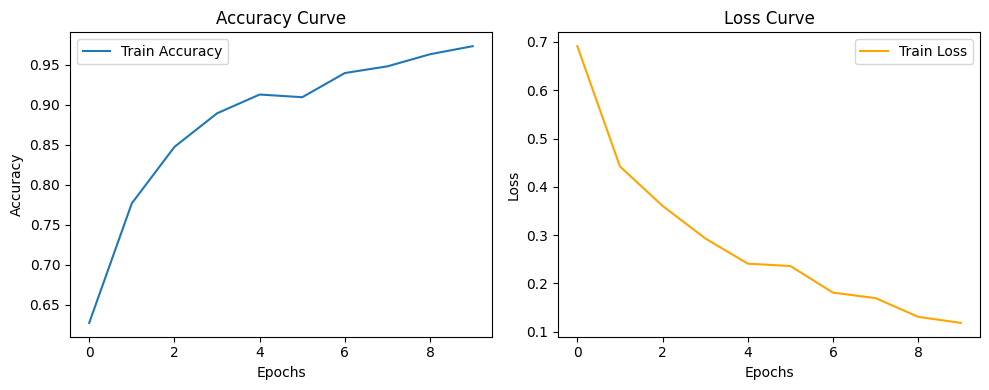


 All results saved to: /content/drive/MyDrive/nnexp7_files


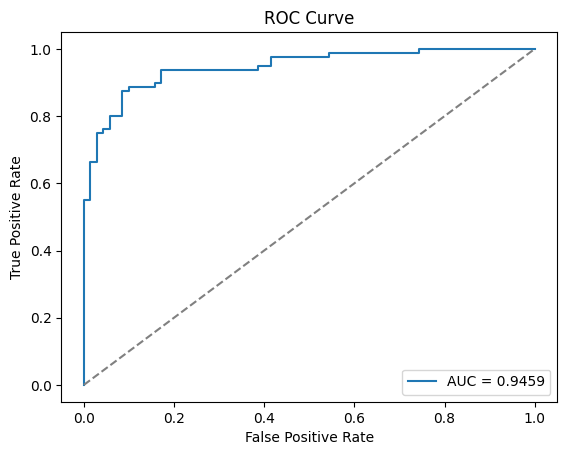

In [ ]:
"""Best accuracy model"""
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')
# 2. Upload ZIP from Local System
from google.colab import files
import zipfile, os

uploaded = files.upload()  # Upload COVID_CT_dataset.zip

for fn in uploaded.keys():
    zip_path = fn
    extract_dir = '/content/covid_data'
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# 3. Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, classification_report, roc_curve
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 4. Dataset Setup
data_dir = os.path.join(extract_dir, 'COVID_CT_dataset')
categories = ['CT_COVID', 'CT_NonCOVID']

filepaths, labels = [], []

for category in categories:
    folder = os.path.join(data_dir, category)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.png', '.jpg', '.jpeg')):
            filepaths.append(os.path.join(folder, fname))
            labels.append(category)

df = pd.DataFrame({'filename': filepaths, 'label': labels})


# 5. Train-Test Split
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# 6. Data Generators
img_size = 224
batch_size = 32

datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(
    train_df, x_col='filename', y_col='label',
    target_size=(img_size, img_size), batch_size=batch_size,
    class_mode='binary'
)

test_gen = datagen.flow_from_dataframe(
    test_df, x_col='filename', y_col='label',
    target_size=(img_size, img_size), batch_size=1,
    class_mode='binary', shuffle=False
)

# 7. Build Model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(img_size, img_size, 3))
base_model.trainable = False

x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# 8. Train Model
history = model.fit(train_gen, epochs=10)

# 9. Evaluate Model
pred_probs = model.predict(test_gen)
preds = (pred_probs > 0.5).astype(int).reshape(-1)
true = test_gen.classes

f1 = f1_score(true, preds)
acc = accuracy_score(true, preds)
auc = roc_auc_score(true, pred_probs)
report = classification_report(true, preds, target_names=test_gen.class_indices.keys())

print("\nClassification Report:\n")
print(report)
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {acc:.4f}")
print(f"AUC: {auc:.4f}")

# 10. Save Results to Google Drive
results_path = '/content/drive/MyDrive/nnexp7_files'
os.makedirs(results_path, exist_ok=True)

# (a) Save metrics
with open(f'{results_path}/metrics_report.txt', 'w') as f:
    f.write("Classification Report:\n")
    f.write(report + '\n')
    f.write(f"F1 Score: {f1:.4f}\n")
    f.write(f"Accuracy: {acc:.4f}\n")
    f.write(f"AUC: {auc:.4f}\n")

# (b) Save model
model.save(f'{results_path}/vgg16_covid_classifier.h5')

# (c) Plot accuracy/loss curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.savefig(f'{results_path}/training_curves.png')
plt.show()

# (d) Plot AUC curve
fpr, tpr, _ = roc_curve(true, pred_probs)
plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.savefig(f'{results_path}/auc_curve.png')

print(f"\n All results saved to: {results_path}")

In [2]:
"""
# Description of Code:
# 1. The model uses a pre-trained VGG16 as the base, keeping its layers frozen to leverage its feature extraction capabilities.
# 2. The base VGG16 model is followed by fully connected layers.
# 3. Fully connected layers (Dense layers) are added with ReLU activations to learn higher-level representations.
# 4. Dropout is applied to prevent overfitting and improve generalization.
# 5. The model ends with a sigmoid output layer for binary classification.
# 6. The model is trained with binary crossentropy loss and an Adam optimizer.
# 7. Performance is evaluated using train los and accuracy curves and f1 score , confusion matrix , area under curve . 
Classification Report:
              precision    recall  f1-score   support

    CT_COVID       0.91      0.83      0.87        70
 CT_NonCOVID       0.86      0.93      0.89        80

    accuracy                           0.88       150
   macro avg       0.88      0.88      0.88       150
weighted avg       0.88      0.88      0.88       150

F1 Score: 0.8916
Accuracy: 0.8800
AUC: 0.9459

PERFORMANCE EVLUATION
# After optimising for 6 cases of fully connected layers , maximum accuracy achieved is 88.00 % . 

MY COMMENTS
# Limitations:
# - The maximum accuracy achieved was 88%, which might not be sufficient.
# - Increasing the number of Dense layers significantly decreased accuracy.
# - BatchNormalization and Global Average Pooling did not improve accuracy .
# - The model is using VGG16 pre-trained weights, which may not generalize well to specific datasets, especially those that differ from the ImageNet dataset.

# Scope for Improvement:
Accuracy can be improved by
# 1. Fine-tuning VGG16 instead of freezing all layers in the VGG16 model.
# 2. Hyperparameter Tuning: The batch size, learning rate, and number of Dense layers could be tuned for better performance.
# 3. More Advanced Architectures ResNet or EfficientNet .s.
# 3. Regularization: Exploring different regularization methods (e.g., L2 regularization) .
# 5. Learning Rate Scheduling: Implementing learning rate decay or using a learning rate scheduler (e.g., ReduceLROnPlateau) .
"""

'\n# Description of Code:\n# 1. The model uses a pre-trained VGG16 as the base, keeping its layers frozen to leverage its feature extraction capabilities.\n# 2. The base VGG16 model is followed by fully connected layers.\n# 3. Fully connected layers (Dense layers) are added with ReLU activations to learn higher-level representations.\n# 4. Dropout is applied to prevent overfitting and improve generalization.\n# 5. The model ends with a sigmoid output layer for binary classification.\n# 6. The model is trained with binary crossentropy loss and an Adam optimizer.\n# 7. Performance is evaluated using train los and accuracy curves and f1 score , confusion matrix , area under curve . \nClassification Report:\n              precision    recall  f1-score   support\n\n    CT_COVID       0.91      0.83      0.87        70\n CT_NonCOVID       0.86      0.93      0.89        80\n\n    accuracy                           0.88       150\n   macro avg       0.88      0.88      0.88       150\nweighte